## This section shows how to use both the text from four json folders and meta data to do a query to search for the information we need

In [3]:
import os
import json
from pprint import pprint
from copy import deepcopy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from subprocess import check_output

###  Part 1: **Load all json and convert to dataframe**
This part can be run in Kaggle. However when doing the tokenizer, the kernel stopped due to memory limit reached.
So it's shown below to demonstrate how to do it. But some parts will be commented out so they are not excuted for the submission

In [ ]:
# this part use functions from kernel CORD-19-EDA,parse JSON and generate clean csv
# https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv
def format_name(author):
    middle_name = " ".join(author['middle'])
    
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))
    
    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []
    
    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)
    
    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    
    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []
    
    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'], 
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files

def generate_clean_df(all_files):
    cleaned_files = []
    
    for file in tqdm(all_files):
        features = [
            file['paper_id'],
            file['metadata']['title'],
            format_authors(file['metadata']['authors']),
            format_authors(file['metadata']['authors'], 
                           with_affiliation=True),
            format_body(file['abstract']),
            format_body(file['body_text']),
            format_bib(file['bib_entries']),
            file['metadata']['authors'],
            file['bib_entries']
        ]

        cleaned_files.append(features)

    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text', 
                 'bibliography','raw_authors','raw_bibliography']

    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    clean_df.head()
    
    return clean_df

In [ ]:
biorxiv_dir = '/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

In [ ]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)
file = all_files[0]
print("Dictionary keys:", file.keys())

In [ ]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        format_authors(file['metadata']['authors']),
        format_authors(file['metadata']['authors'], 
                       with_affiliation=True),
        format_body(file['abstract']),
        format_body(file['body_text']),
        format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)
len(cleaned_files)

In [ ]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns=col_names)
clean_df.head(5)

In [ ]:
#clean_df.to_csv('biorxiv_clean.csv', index=False)
pmc_dir = '/kaggle/input/CORD-19-research-challenge/custom_license/custom_license/pdf_json/'
pmc_files = load_files(pmc_dir)
pmc_df = generate_clean_df(pmc_files)
#pmc_df.to_csv('clean_pmc.csv', index=False)
#pmc_df.head()
comm_dir = '/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/'
comm_files = load_files(comm_dir)
comm_df = generate_clean_df(comm_files)
#comm_df.to_csv('clean_comm_use.csv', index=False)
#comm_df.head()
noncomm_dir = '/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json/'
noncomm_files = load_files(noncomm_dir)
noncomm_df = generate_clean_df(noncomm_files)
#noncomm_df.to_csv('clean_noncomm_use.csv', index=False)
#noncomm_df.head()


In [ ]:
#check the number of json files from each directory
print(len(clean_df))
print(len(pmc_df))
print(len(comm_df))
print(len(noncomm_df))

In [ ]:
bigdata1 = pd.concat([clean_df, pmc_df], ignore_index=True, sort =False)
bigdata2 = pd.concat([comm_df, noncomm_df], ignore_index=True, sort =False)
final_df = pd.concat([bigdata1, bigdata2], ignore_index=True, sort =False)
print(len(final_df))
#final_df.to_csv('alljson.csv', index=False)
del clean_df,pmc_df,comm_df,noncomm_df,bigdata1,bigdata2

In [ ]:
#final_df.columns

In [ ]:
#final_df['paper_id'][:5]

### Part 2: **Loading the metadata**

In [4]:
meta_df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv') # 
 
nRow, nCol = meta_df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 29500 rows and 14 columns


In [5]:
meta_df.head(5)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [6]:
meta_df.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text'],
      dtype='object')

In [7]:
meta_df['sha'].isna().sum()  # null id number

12080

In [64]:
meta_df1=meta_df[meta_df['sha'].notnull()]
print(len(meta_df1))

17420


### Part 3: Merge two dataframes, metadata and all json text

In [ ]:
"""
# If we want to merge the two data frames, meta_df1 is from meta data, and final_df is from json and has text info
# but running on Kaggle encountered the memory issue, so this part is only if your machine has enough memory and 
# finding out how many paper id from json overlaps with metadata sha, so we can merge them together
print(len(list(set(meta_df1['sha'])&set(final_df['paper_id']))))
#merge two dataframes
pd_merge_all= pd.merge(meta_df1, final_df, how='inner',left_on='sha', right_on='paper_id')
print(len(pd_merge_all))
# remove some duplicate columns
pd_merge_all=pd_merge_all[['cord_uid', 'sha', 'source_x', 'title_x', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract_x', 'publish_time', 'authors_x', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url', 'affiliations', 'text', 'bibliography',
       'raw_authors', 'raw_bibliography']]
pd_merge_all=pd_merge_all.dropna(subset=['sha', 'text'])  # drop if any of these two columns have nan

"""

In [65]:
# since we didn't use the above step, so use meta data only
pd_merge_all=meta_df1

In [66]:
pd_merge_all.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


###  Part 4   NLP processing 

In [12]:
import re
import nltk
import string

In [73]:
# remove nan titles
print(len(pd_merge_all))
pd_merge_all=pd_merge_all[pd_merge_all['title']!='nan']
# remove nan abstracts
print(len(pd_merge_all))
pd_merge_all=pd_merge_all[pd_merge_all['abstract']!='nan']
print(len(pd_merge_all))

17420
17420
17420


  #### Normalization of text
The following was only done to metadata abstract text, it can be easily done to alljson dataframe text column, but due to memory limit, only show the process to abstract 

In [70]:
# data cleaning
def clean_dfonecol(new_df,col):
    new_df=new_df.replace(np.nan,'',regex = True)
    new_df = new_df[pd.notnull(new_df[col])] 
    #print(len(new_df))
    # lower case
    new_df[col] = new_df[col].apply(lambda x: x.lower()) 
    #punctuation
    new_df[col] = new_df[col].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    return new_df

# below is the data with full text info, for now, dropped
#pd_merge_all=clean_dfonecol(pd_merge_all,'title_x')
#print(len(pd_merge_all))
#pd_merge_all=clean_dfonecol(pd_merge_all,'abstract_x')
#print(len(pd_merge_all))
#pd_merge_all=clean_dfonecol(pd_merge_all,'text')    # too much text to process
#print(len(pd_merge_all))

In [16]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
    
def remv_stopwords(new_df,col):
# remove stopwords
    
    new_df[col]= new_df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    new_df[col]= new_df[col].str.findall('\w{2,}').str.join(' ')
    return new_df

#pd_merge_all=remv_stopwords(pd_merge_all,'abstract_x')
#pd_merge_all=remv_stopwords(pd_merge_all,'text') # takes too much memory, so not runnning it

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tina.T.Zhao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


##### Since text column will take a lot of memory, will only perform on abstract for now

In [74]:
# only process abstract from meta_df1
#print(len(meta_df1))
meta_df1=clean_dfonecol(pd_merge_all,'abstract')
print(len(meta_df1))

17420


In [75]:
#print(len(meta_df1))
meta_df1=remv_stopwords(meta_df1,'abstract')
print(len(meta_df1))

17420


In [76]:
meta_df1.reset_index(inplace=True)

### Text processing

In [77]:
# put all abstract in one list, sentence by sentence
text1=[]
for i in range(len(meta_df1)):
    text1.append(meta_df1['abstract'].loc[i])

# put all, by words
text2=[]  
for i in range(len(meta_df1)):
    text2.append(meta_df1['abstract'].loc[i].split())

In [78]:
import gensim
from gensim import corpora
from pprint import pprint
# Create dictionary by using all the words
dictionary = corpora.Dictionary(text2)

In [79]:
# Get information about the dictionary
print(dictionary)

Dictionary(80781 unique tokens: ['13', '14', '17', '2019', '2ndash14']...)


In [26]:
#print(dictionary.token2id[) 

In [80]:
# Create the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in text2]
#pprint(mycorpus[:10])   # this will show the token and its frequency in the text 

In [30]:
# create word count
word_counts = [[(mydict[id], count) for id, count in line] for line in mycorpus]
#pprint(word_counts[:100]) 

In [89]:
#import gensim.downloader as api
#dataset = api.load("text8")

In [35]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

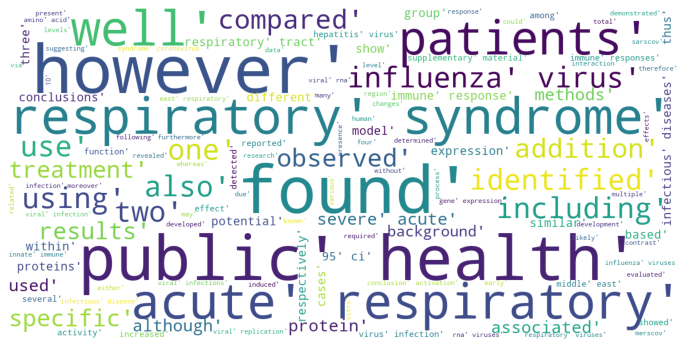

In [36]:
show_wordcloud(text2)

In [37]:
# Use gensim summarization 
from gensim.summarization import summarize, keywords
#from pprint import pprint

In [42]:
# Important keywords from the paragraph
print(text1[100])  # one abstract example
# the keyword from this paragraph
print(keywords(text1[100]))  

outbreak pneumonia originating wuhan china generated 24500 confirmed cases including 492 deaths february 2020 virus 2019ncov spread elsewhere china 24 countries including south korea thailand japan usa fortunately limited humantohuman transmission outside china assess risk sustained transmission whenever coronavirus arrives countries data describing times symptom onset hospitalisation 47 patients infected early current outbreak used generate estimate probability imported case followed sustained humantohuman transmission assumptions imported case representative patients china 2019ncov similarly transmissible sars coronavirus probability imported case followed sustained humantohuman transmission 041 credible interval 027 055 however mean time symptom onset hospitalisation halved intense surveillance probability imported case leads sustained transmission 0012 credible interval 0099 emphasises importance current surveillance efforts countries around world ensure ongoing outbreak become glo

In [48]:
# Summarize the paragraph
# need the comma to distinguish the sentences, just one example below
text1examp="outbreak pneumonia originating wuhan china generated 24500 confirmed cases including 492 deaths. february \
2020 virus 2019ncov spread elsewhere china, 24 countries including south korea, thailand, japan, usa. fortunately limited \
humantohuman transmission outside china. assess risk sustained transmission whenever coronavirus arrives countries. data \
describing times symptom onset hospitalisation. 47 patients infected. early current outbreak used generate estimate \
probability. imported case followed sustained humantohuman transmission assumptions. imported case representative  \
patients china. 2019ncov similarly transmissible sars. coronavirus probability imported case followed sustained  \
humantohuman transmission. 041 credible interval. however mean time symptom onset hospitalisation halved.  \
intense surveillance probability imported case leads sustained transmission. 0012 credible interval. 0099 emphasises. \
importance current surveillance efforts. countries around world ensure ongoing outbreak become global pandemic."
pprint(summarize(text1examp, word_count=20)) # this will be good for full text summarize

('imported case followed sustained humantohuman transmission assumptions.\n'
 'coronavirus probability imported case followed sustained  humantohuman '
 'transmission.\n'
 'intense surveillance probability imported case leads sustained transmission.')


#### It shows that abstracts  has 112323 unique tokens from 29500 papers, this number will change with added papers

### Part 5:  **Search Use BM25**

The bm25 rank feature implements the Okapi BM25 ranking function used to estimate the relevance of a text document given a search query. It is a pure text ranking feature which operates over an indexed string field. The feature is very cheap to compute, about 3-4 times faster than nativeRank, while still providing a good rank score quality wise. It is a good candidate to use in a first phase ranking function when ranking text documents.

The bm25 feature calculates a score for how good a query with terms q1,...,qn
 matches an indexed string field t in a document D. The score is calculated as follows:
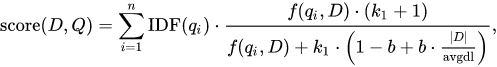
where f(qi,D) is qi's term frequency in the document D, |D| is the length of the document D in words, and avgdl is the average document length in the text collection from which documents are drawn. k1 and b are free parameters, usually chosen, in absence of an advanced optimization. IDF(qi) is the IDF (inverse document frequency) weight of the query term qi. It is usually computed as:

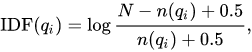
where N is the total number of documents in the collection, and n(qi) is the number of documents containing qi.

In [81]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
# tockenize abstract
meta_df_tokens = meta_df1.abstract.fillna('').apply(preprocess_string) 

In [54]:
!pip install rank_bm25

  Created wheel for rank-bm25: filename=rank_bm25-0.2-py3-none-any.whl size=4167 sha256=14d2e093d26cc71e4aece02dc7511fa122e78a18157578c08b2b286379df8459
  Stored in directory: c:\users\tina.t.zhao\appdata\local\pip\cache\wheels\a7\ae\a2\bc836dd67721b123fe31c3d4dce111ff782f898e7c7fdabc7f
Successfully built rank-bm25


In [55]:
from rank_bm25 import BM25Okapi

# tockenize abstract
#pd_merge_abstract_tokens = pd_merge_all.abstract_x.fillna('').apply(preprocess_string)  # tokenize each abstract to word
# tockenize the text, this is too memory consuming to be run on kaggle machine
#pd_merge_text_tokens = pd_merge_all.text.fillna('').apply(preprocess_string)  # tokenize each textto word

In [82]:
meta_df_tokens[:100]

0                                                    []
1                                                    []
2     [geograph, spread, novel, coronaviru, covid, i...
3     [decemb, case, unidentifi, pneumonia, histori,...
4                                                    []
                            ...                        
95    [export, case, novel, coronaviru, covid, infec...
96    [rapid, diagnost, vaccin, therapeut, import, i...
97    [sever, respiratori, ongo, outbreak, pneumonia...
98                                                   []
99                                                   []
Name: abstract, Length: 100, dtype: object

In [84]:
from nltk.corpus import wordnet
nltk.download('wordnet')
def find_syn_ant(word):
    synonyms = []
    antonyms = []

    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
            if l.antonyms():
                antonyms.append(l.antonyms()[0].name())

    #print(set(synonyms))
    #print(set(antonyms))
    return set(synonyms)

print(find_syn_ant("smoking"))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tina.T.Zhao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


{'smoking', 'smoke', 'fume'}


Create a BM25Okapi index from the tokens. Implement a search function that returns the top 10 results from the search. Note that in search wer are asking the index to return the dataframe indexes of the tokens most similar to the search string.

In [85]:
bm25_index = BM25Okapi(meta_df_tokens.tolist())

def search(search_string, num_results=10):  # can change the num_results to top 50 or more
    search_tokens = preprocess_string(search_string)
    scores = bm25_index.get_scores(search_tokens)
    top_indexes = np.argsort(scores)[::-1][:num_results]
    return top_indexes

In [89]:
# example: now show the abstract of the top index
meta_df1.loc[search('novel coronavirus treatment')][['abstract', 'publish_time']]

,abstract,publish_time
93,outbreak respiratory illness proved infected 2...,2020
15391,global outbreak severe acute respiratory syndr...,2004 Feb
16934,2019ncov novel coronavirus emerged wuhan china...,2020-02-03
144,objective study execute rational screen identi...,2020
106,december 2019 coronavirus disease 2019 covid19...,2020
17046,sarscov2 novel coronavirus cov recently emerge...,2020-03-09
61,late december 2019 previous unidentified coron...,2020
16923,emergence novel highly pathogenic coronavirus ...,2020-01-31
165,novel coronavirus 2019ncov outbreak initially ...,2020
12579,identification novel coronavirus ncov causativ...,2013 Apr 18


### Below are the ones we need to check related to different risk factors:

- Data on potential risks factors
        - Smoking, pre-existing pulmonary disease
        - Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
        - Neonates and pregnant women
        - Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
- Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
- Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
- Susceptibility of populations
- Public health mitigation measures that could be effective for control

In [96]:
# Now break the above questions to the following search strings
string1='smoking, pre-existing pulmonary disease'
string2= 'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities'
string3= 'Neonates and pregnant women'
string4=  'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences'
string5= 'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors'
string6=  'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups'
string7=  'Susceptibility of populations'
string8= 'Public health mitigation measures that could be effective for control'

In [98]:
meta_df1.loc[search(string1)][['abstract', 'publish_time']]

,abstract,publish_time
9182,data exist usefulness delta neutrophil index d...,2018 Aug 17
4585,daily oscillations pulmonary function depend r...,2015 Apr 29
4584,daily oscillations pulmonary function depend r...,2015 Apr 29
10341,case presentation clinical case presents histo...,2019 Mar 6
12470,introduction chronic obstructive pulmonary dis...,2012 May 9
4201,acute respiratory distress syndrome ards chara...,2014 Aug 22
3044,background carcinoembryonic antigen cearelated...,2013 Aug 14
13720,background human coronaviruses cov long recogn...,2017 Oct 4
13530,identifying asthma triggers forms basis enviro...,2017 Mar 7
11361,among chief limitations achieving early detect...,2019 Nov 23


In [100]:
meta_df1.loc[search(string2)][['abstract', 'publish_time']]

,abstract,publish_time
14526,combination high rates mutation replication co...,2019 Aug 22
11535,novel infectious diseases continue emerge with...,2019 Nov 26
11534,novel infectious diseases continue emerge with...,2019 Nov 26
11533,novel infectious diseases continue emerge with...,2019 Nov 26
11532,novel infectious diseases continue emerge with...,2019 Nov 26
16744,novel infectious diseases continue emerge with...,2019-03-19
7395,severe acute respiratory syndrome sars new inf...,2005 Jan 20
11310,although concept highlevel containment care hl...,2019 Aug 22
13343,vivo serial passage nonpathogenic viruses show...,2016 Apr 9
11163,porcine epidemic diarrhea virus pedv enteric c...,2019 Jul 25


In [101]:
meta_df1.loc[search(string3)][['abstract', 'publish_time']]

,abstract,publish_time
8333,vaccination mainstay preventative medicine man...,2018 Feb 1
8543,investigate factors associated death describe ...,2018 Mar 26
44,early december 2019 cluster cases pneumonia un...,2020
14891,planning future influenza pandemic include con...,2008 Jan
941,background little known optimismpessimism heal...,2009 Sep 1
16225,human metapneumovirus hmpv respiratory virus c...,2017 Aug
13315,objective describe clinical aspects cases infl...,2015 Apr-Jun
15513,emerging infectious disease outbreaks bioterro...,2006 Nov
15511,key component response emerging infections con...,2006 Nov
11856,association zika virus zikv infection severe c...,2020 Jan 30


In [102]:
meta_df1.loc[search(string4)][['abstract', 'publish_time']]

,abstract,publish_time
15864,mathematical epidemiology one oldest richest a...,2014 Sep 19
4797,study evaluates economic consequences hypothet...,2015 Jun 26
12343,purpose new strain h1n1 subtype influenza viru...,2011 Jan 1
2964,harmful nonindigenous species nis impose great...,2013 Aug 9
5746,recent research suggested significant negative...,2016 Apr 8
14302,background burden disease used prioritize heal...,2019 Mar 7
15962,background influenza respiratory infections ca...,2013 Nov 6
13440,result rapid economic growth previous three de...,2016 Nov 29
12618,last years intensive worldwide effort speeding...,2013 May 15
9032,background epidemics sars h7n9 caused huge neg...,2018 Jun 28


In [103]:
meta_df1.loc[search(string5)][['abstract', 'publish_time']]

,abstract,publish_time
13227,objectives outbreak middle eastern respiratory...,2016 Feb 18
16116,please cite paper boëlle et al 2011 transmissi...,2011 Sep 31
435,background time variations transmission potent...,2007 Jun 4
493,background heightened increase concern influen...,2008 Jan 30
9375,hepatitis caused hepatitis virus occurs worldw...,2018 Sep 24
12915,objectives estimate transmissibility ice bucke...,2014 Dec 16
12914,objectives estimate transmissibility ice bucke...,2014 Dec 16
5512,background accurately assessing transmissibili...,2016 Feb 5
10819,background summer 2014 autochthonous outbreak ...,2019 Jun 21
10139,analysing new emerging infectious disease outb...,2019 Jan 16


In [104]:
meta_df1.loc[search(string6)][['abstract', 'publish_time']]

,abstract,publish_time
8665,background respiratory syncytial virus rsv rec...,2018 May 4
3154,background 2009 severe fever thrombocytopenia ...,2013 Nov 13
1624,background hospitals often epicentres newly ci...,2011 Jul 8
3517,background influenza ah7n9 viruses isolated hu...,2014 Apr 15
4389,casecontrol study aimed assess risk factors de...,2015 Mar 16
6976,objectives renal involvement scrub typhus rang...,2017 Mar 15
10538,mycetoma neglected tropical disease endemic ma...,2019 Apr 4
1426,background streptococcus suis infection emergi...,2011 Mar 8
11416,background 2015 south korea experienced outbre...,2019 Oct 30
1726,background 31st march 2010 127000 confirmed ca...,2011 Oct 12


In [105]:
meta_df1.loc[search(string7)][['abstract', 'publish_time']]

,abstract,publish_time
7215,objective tuberculosis tb caused infection myc...,2017 May 4
2828,genetic analysis pathogen genomes powerful app...,2013 Mar 19
4673,background bovine respiratory disease complex ...,2014 Dec 22
4671,background bovine respiratory disease complex ...,2014 Dec 22
4672,background bovine respiratory disease complex ...,2014 Dec 22
4670,background bovine respiratory disease complex ...,2014 Dec 22
4674,background bovine respiratory disease complex ...,2014 Dec 22
4676,background bovine respiratory disease complex ...,2014 Dec 22
4675,background bovine respiratory disease complex ...,2014 Dec 22
804,background pathogenesis severe acute respirato...,2009 May 1


In [106]:
meta_df1.loc[search(string8)][['abstract', 'publish_time']]

,abstract,publish_time
14899,report results national survey conducted help ...,2008 May
14898,report results national survey conducted help ...,2008 May
16250,published guidance recommends controlled movem...,2017 Dec
14746,aerial spraying products kill larvae adult mos...,2020 Jan 25
10209,transmission infectious microbes via bioaeroso...,2019 Feb 21
2282,recently pointed institute medicine existing p...,2011 Jun 5
449,background influenza pandemic preparedness pla...,2007 Jul 13
1258,background emergence influenza h1n1v world fac...,2010 Sep 3
15151,recently pointed institute medicine existing p...,2010 Jul 7
7861,background 2006 malawi developed national infl...,2017 Jul 28


#### The above search is fast, but the search is only within the abstracts from meta data. If we have more memory, we can use the combined abstract and text data and search from text directly. It may significantly improve the query relevance score